In [145]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_csv("../sp500_ohlcv_2005_2025_2.csv")
sp500 = pd.read_csv("../sectors.csv")

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)

df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Sector
0,2005-01-03,MMM,37.356306,37.915495,37.301752,37.460873,3817632.0,Industrials
1,2005-01-04,MMM,37.460883,37.742749,37.129005,37.156284,4358942.0,Industrials
2,2005-01-05,MMM,37.142662,37.256318,36.701679,36.701679,3462779.0,Industrials
3,2005-01-06,MMM,36.769829,37.460855,36.742550,37.033508,3605342.0,Industrials
4,2005-01-07,MMM,37.051714,37.642720,36.938058,37.415409,3938428.0,Industrials


In [11]:

# Suppose df a les colonnes : Date, Ticker, Open, High, Low, Close, Volume
df = df.sort_values(["Ticker", "Date"])

# --- 1) Log-return
df["log_return"] = np.log(df["Close"]) - np.log(df["Close"].shift(1))

# --- 2) Target = log-return de demain (r_{t+1})
df["target"] = df.groupby("Ticker")["log_return"].shift(-1)

# --- 3) Features momentum
df["mom_5"]  = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(5) - 1)
df["mom_21"] = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(21) - 1)

# --- 4) Features volatilité
df["vol_5"]  = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(5).std())
df["vol_21"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(21).std())

# --- 5) High–Low range
df["range"] = (df["High"] - df["Low"]) / df["Open"]

# --- 6) Volume z-score
df["volume_z"] = df.groupby("Ticker")["Volume"].transform(
    lambda x: (x - x.mean()) / x.std()
)

df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# --- 7) Clean
df = df.dropna()


In [24]:
df["target"].describe()

count    2.241893e+06
mean     4.525353e-04
std      2.193297e-02
min     -9.362585e-01
25%     -8.503411e-03
50%      6.504227e-04
75%      9.758683e-03
max      7.048674e-01
Name: target, dtype: float64

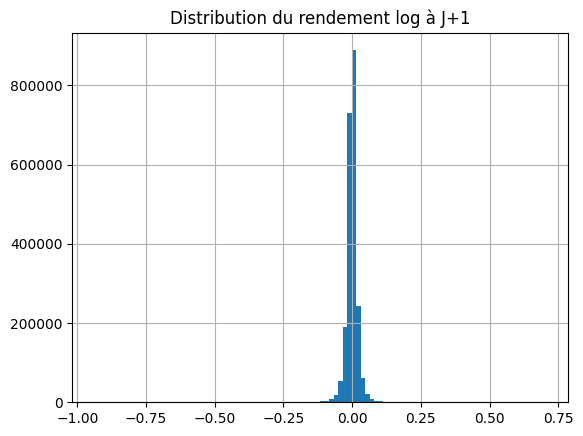

In [26]:
import matplotlib.pyplot as plt

df["target"].hist(bins=100)
plt.title("Distribution du rendement log à J+1")
plt.show()


<Axes: >

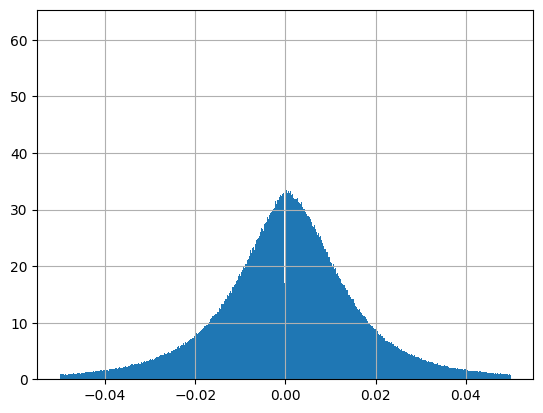

In [27]:
df['Return'].dropna().hist(bins=500, density=True, range=(-0.05, 0.05))

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def regression(df, features):

    # --- 8) Train/val/test split
    # On restreint à la période 2010–2021 (à adapter si besoin)
    mask = (df["Date"] >= "2010-01-01") & (df["Date"] <= "2021-12-31")
    df_period = df[mask].copy()
    
    # On mélange les dates de façon aléatoire
    unique_dates = df_period["Date"].unique()
    rng = np.random.default_rng(seed=42)  # pour reproductibilité
    rng.shuffle(unique_dates)
    
    n_dates = len(unique_dates)
    n_train = int(0.6 * n_dates)
    n_val   = int(0.2 * n_dates)
    # le reste (~20%) pour le test
    
    train_dates = unique_dates[:n_train]
    val_dates   = unique_dates[n_train:n_train + n_val]
    test_dates  = unique_dates[n_train + n_val:]
    
    train = df_period[df_period["Date"].isin(train_dates)]
    val   = df_period[df_period["Date"].isin(val_dates)]
    test  = df_period[df_period["Date"].isin(test_dates)].copy()


    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédictions sur le test
    y_pred = model.predict(X_test)

    # --- Autres métriques globales (régression)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    var_test = np.var(y_test)

    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)
    print("Var(y_test) :", var_test)
    
    test["pred"] = y_pred

    sector_rmse = (
        test.groupby("Sector")
            .apply(
                lambda g: np.sqrt(mean_squared_error(g["target"], g["pred"])),
                include_groups=False
            )
            .sort_values()
    )
    return  model, sector_rmse


In [94]:
regression(df, ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])


RMSE : 0.020784820415877425
MAE  : 0.012943698667066392
R²   : -0.007592885172561292
Var(y_test) : 0.00042875328525795287


(LinearRegression(),
 Sector
 Consumer Staples          0.015676
 Utilities                 0.016087
 Real Estate               0.019063
 Health Care               0.019286
 Financials                0.019381
 Industrials               0.020472
 Materials                 0.021881
 Information Technology    0.023037
 Communication Services    0.023228
 Consumer Discretionary    0.023928
 Energy                    0.027018
 dtype: float64)

In [201]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def xgb(df, features, H):

    df = df.copy()   # <- ajoute ça
    # target : moyenne des log_return sur les H prochains jours
    df["target"] = (
        df.groupby("Ticker")["log_return"]
          .transform(lambda s: s.rolling(H).mean().shift(-H))
    )
    
    # date de réalisation de la target = date du dernier jour utilisé
    df["target_date"] = df.groupby("Ticker")["Date"].shift(-H)
    
    # enlever les lignes sans target (bord de série)
    df = df.dropna(subset=["target", "target_date"])
    
    # --- Train/val/test split temporel ---
  # 1) Restriction à la période 2010–2021
    mask = (df["Date"] >= "2010-01-01") & (df["Date"] <= "2021-12-31")
    df_period = df[mask].copy()
    
    # 2) Dates disponibles dans cette période
    all_dates = np.sort(df_period["Date"].unique())
    
    # 3) Thinning pour éviter le leak (H connu)
    used_dates = all_dates[::(H + 1)]
    
    n = len(used_dates)
    i1 = int(0.6 * n)
    i2 = int(0.8 * n)
    
    train_dates = used_dates[:i1]
    val_dates   = used_dates[i1:i2]
    test_dates  = used_dates[i2:]
    
    # 4) Split final
    train = df_period[df_period["Date"].isin(train_dates)]
    val   = df_period[df_period["Date"].isin(val_dates)]
    test  = df_period[df_period["Date"].isin(test_dates)].copy()

    X_train, y_train = train[features], train["target"]
    X_val,   y_val   = val[features],   val["target"]
    X_test,  y_test  = test[features],  test["target"]

    # --- Modèle XGBoost ---
    model = XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=30,

    )

    # --- Entraînement ---
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # --- Prédiction ---
    y_pred = model.predict(X_test)

    # --- Métriques globales ---
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)
    var_test = np.var(y_test)

    print("RMSE :", rmse)
    print("MAE  :", mae)
    print("R²   :", r2)
    print("Var(y_test) :", var_test)
    
    # --- Prédiction stockée ---
    test["pred"] = y_pred

    # --- RMSE par secteur ---
    sector_rmse = (
        test.groupby("Sector")
            .apply(lambda g: r2_score(g["target"], g["pred"]),
                   include_groups=False)
            .sort_values()
    )

    return sector_rmse, r2


In [174]:
xgb(df, ["Open", "Close", "High", "Low", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.02525020689884503
MAE  : 0.016133073317881046
R²   : 0.0010314631480425884
Var(y_test) : 0.0006382312604595739


Sector
Energy                   -0.001543
Health Care              -0.000285
Industrials               0.000430
Consumer Discretionary    0.000727
Materials                 0.000735
Financials                0.001149
Information Technology    0.001224
Communication Services    0.001735
Utilities                 0.001846
Real Estate               0.002569
Consumer Staples          0.003869
dtype: float64

on va changer la variable à prédire en passant sur le retour avec un horizon de 5 jours pour prendre une variable à prédire moins sensible au bruit

In [180]:
xgb(df, ["Open", "Close", "High", "Low", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 51)


RMSE : 0.0032902611789194813
MAE  : 0.002331911638251957
R²   : 0.01837812586997667
Var(y_test) : 1.1028501820111898e-05


Sector
Utilities                -0.040490
Health Care               0.002858
Information Technology    0.008605
Consumer Staples          0.010894
Communication Services    0.017221
Real Estate               0.018945
Industrials               0.020059
Financials                0.020201
Consumer Discretionary    0.020500
Energy                    0.022741
Materials                 0.035993
dtype: float64

In [211]:
xgb(df, [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 21)

RMSE : 0.006067415008065985
MAE  : 0.003990378179187112
R²   : 0.0016602663821293495
Var(y_test) : 3.6874746782536945e-05


(Sector
 Information Technology   -0.012521
 Utilities                -0.010661
 Energy                   -0.003611
 Health Care               0.000049
 Industrials               0.000544
 Communication Services    0.001002
 Consumer Discretionary    0.001067
 Materials                 0.001635
 Consumer Staples          0.004288
 Financials                0.005653
 Real Estate               0.005718
 dtype: float64,
 0.0016602663821293495)


=== H = 1 ===
RMSE : 0.02525020689884503
MAE  : 0.016133073317881046
R²   : 0.0010314631480425884
Var(y_test) : 0.0006382312604595739

=== H = 3 ===
RMSE : 0.014454866114521223
MAE  : 0.009361034968528083
R²   : -0.00017245732793136348
Var(y_test) : 0.000208907126823856

=== H = 5 ===
RMSE : 0.012162431074514837
MAE  : 0.007597634176546208
R²   : 0.0016970929795067091
Var(y_test) : 0.00014817619842840698

=== H = 10 ===
RMSE : 0.006851046464937372
MAE  : 0.004711060356059577
R²   : -0.004278660139880097
Var(y_test) : 4.673686649698731e-05

=== H = 15 ===
RMSE : 0.006067698260771934
MAE  : 0.003990609021397778
R²   : 0.0015670507272350642
Var(y_test) : 3.6874746782536945e-05

=== H = 21 ===
RMSE : 0.005133218247104057
MAE  : 0.0033856668648567603
R²   : 0.007503416368397686
Var(y_test) : 2.6549138815154544e-05

=== H = 26 ===
RMSE : 0.00498397079587138
MAE  : 0.0032825911126867953
R²   : 0.0027011351084387236
Var(y_test) : 2.4907242721869243e-05

=== H = 30 ===
RMSE : 0.004877217580424

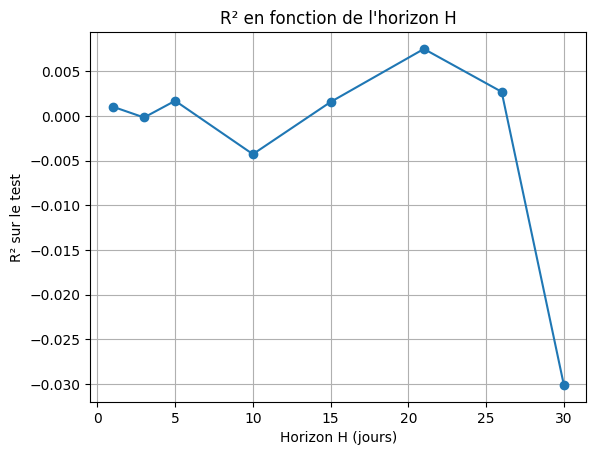

In [213]:
import matplotlib.pyplot as plt

features = ["Open", "Close", "High", "Low", "mom_5", "mom_21",
            "vol_5", "vol_21", "range", "volume_z"]

horizons = [1, 3, 5, 10, 15, 21, 26, 30]
r2_values = []

for H in horizons:
    print(f"\n=== H = {H} ===")
    _, r2 = xgb(df, features, H)
    r2_values.append(r2)

plt.figure()
plt.plot(horizons, r2_values, marker="o")
plt.xlabel("Horizon H (jours)")
plt.ylabel("R² sur le test")
plt.title("R² en fonction de l'horizon H")
plt.grid(True)
plt.show()


In [163]:
def xgb_sector(df, sector, features, H):
    # 1) On filtre les données du secteur
    df_sec = df[df["Sector"] == sector].copy()
    
    # 2) On réutilise exactement ta fonction xgb sur ce sous-ensemble
    return xgb(df_sec, features, H)


In [184]:
xgb_sector(df, "Consumer Staples", [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.01808754938744918
MAE  : 0.011642231037344606
R²   : 0.0023685576051029056
Var(y_test) : 0.000327936178573161


Sector
Consumer Staples    0.002369
dtype: float64

In [190]:
def xgb_ticker(df, ticker, features, H):
    # 1) On filtre les données du secteur
    df_sec = df[df["Ticker"] == ticker].copy()
    
    # 2) On réutilise exactement ta fonction xgb sur ce sous-ensemble
    return xgb(df_sec, features, H)


In [199]:
xgb_ticker(df, "VZ", [ "Close", "Low", "High", "Open", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"], 1)

RMSE : 0.01149593542438108
MAE  : 0.007837769066837516
R²   : 0.009045306008698795
Var(y_test) : 0.0001333628389702142


Sector
Communication Services    0.009045
dtype: float64